# First contact
Open the files, load an image and show it

In [120]:
import pandas as pd

train = pd.read_csv("../data/base/train.csv", nrows=100)
test = pd.read_csv("../data/base/test.csv", nrows=100)
submission = pd.read_csv("../data/base/sample_submission.csv", nrows=100)
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train.shape

(100, 785)

In [124]:
images = train.iloc[:, 1:]
images.shape

(100, 784)

In [125]:
first_image = images.iloc[0].as_matrix()
first_image.shape

(784,)

In [13]:
import numpy as np
np.sqrt(784)

28.0

In [15]:
first_image.reshape((28, 28)).shape

(28, 28)

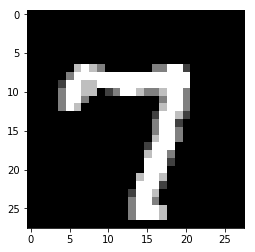

In [129]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(images.sample(1).as_matrix().reshape((28, 28)), cmap='gist_gray');

# Second contact
Load the csvs, checkout the sizes

Train: (42000, 785) 
  X: (42000, 784)
  y: (42000,)
Test: (28000, 784)
Sample: (28000, 2)


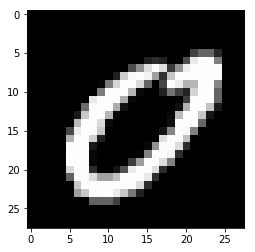

In [202]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

DATA = '../data'
TRAIN = f'{DATA}/base/train.csv'
TEST = f'{DATA}/base/test.csv'
SAMPLE_SUBMISSION = f'{DATA}/base/sample_submission.csv'

def read(file_path, nrows=None):
    return pd.read_csv(file_path, nrows=nrows)

def show_sample(X):
    plt.imshow(X.sample(1).as_matrix().reshape((28, 28)), cmap='gist_gray');

train = read(TRAIN)
X_submit = read(TEST)
sample_submission = read(SAMPLE_SUBMISSION) # 0.10014

X = train.iloc[:, 1:]
y = train.iloc[:, 0]

print(f"Train: {train.shape} \n  X: {X.shape}\n  y: {y.shape}\nTest: {X_submit.shape}\nSample: {sample_submission.shape}")
show_sample(X)

## Sample submission

The sample submission achieves a categorization precision of 0.10014, which today is rank 2789th out of 2806: just at 15 positions from the absolute bottom. It consist of a 1-indexed list of zeros. The submission can be reproduced using the script `submit.sh` as follows:

```bash

cp data/base/sample_submission.csv data/submissions/
./scripts/submit.sh sample_submission.csv "This is the sample submission"
```

In [132]:
sample_submission.set_index("ImageId").head(3)

,Label
ImageId,
1,0
2,0
3,0


# Trivial improvement to sample submission

Replace the zeros with the `mode` value (the digit which appears most times).

First let's see the mode value:

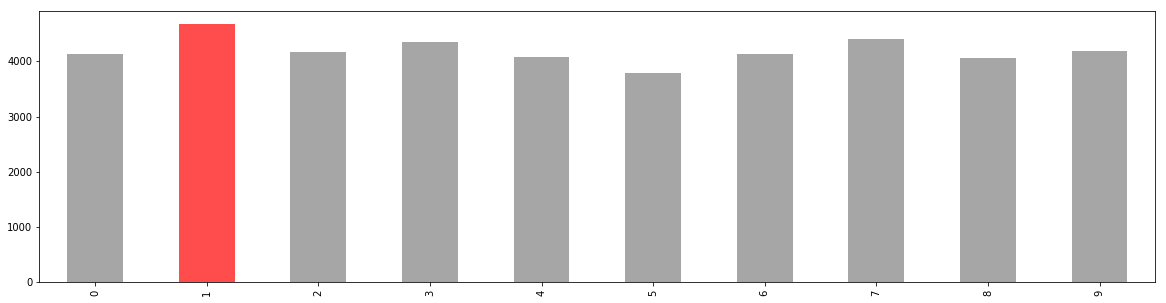

In [133]:
y.value_counts().sort_index().plot(kind='bar', figsize=(20, 5), alpha=0.7, 
                                   color=['r' if i == y.mode()[0] else 'gray' for i in range(10)]);

In [134]:
pd.DataFrame((y.value_counts().sort_index() / y.count()).round(3)).rename(columns={'label': 'Percentage'})

,Percentage
0,0.098
1,0.112
2,0.099
3,0.104
4,0.097
5,0.090
6,0.098
7,0.105
8,0.097
9,0.100


In [110]:
sample_submission['Label'] = 1
sample_submission.to_csv(f"{DATA}/submissions/dummy_all_ones.csv", index=False)

In [111]:
!head ../data/submissions/dummy_all_ones.csv

ImageId,Label
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


This submission achieves a score of 0.11614 and a position of 2745, advancing 44 positions and moving from 99 to 97% of the leaderboard: 
```
./scripts/submit.sh dummy_all_ones.csv "Dummy all ones"
```

# Sum correlation
Just checking some simple stupid ideas. Try to use a linear classifier using just the overall brightness of the image doesn't work. The LogReg just outputs always `0`.

In [298]:
df = pd.concat([pd.get_dummies(y), X.sum(axis=1)], axis=1)
df.columns = list(range(10)) + ['Brightness']
df.head(3)

,0,1,2,3,4,5,6,7,8,9,Brightness
0,0,1,0,0,0,0,0,0,0,0,16649
1,1,0,0,0,0,0,0,0,0,0,44609
2,0,1,0,0,0,0,0,0,0,0,13425


,0,1,2,3,4,5,6,7,8,9
Brightness,0.32,-0.45,0.14,0.08,-0.07,-0.01,0.06,-0.13,0.15,-0.06


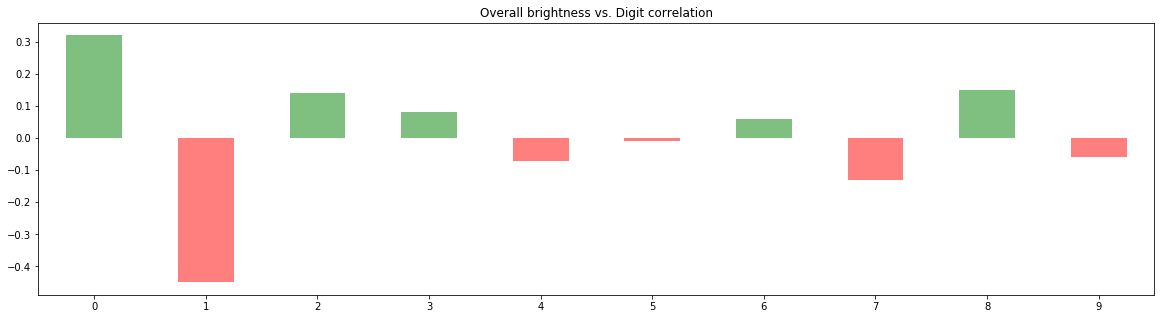

In [310]:
corr = df.corr()['Brightness'][0:10].round(2)
corr.plot(kind='bar', figsize=(20, 5), color=['g' if c > 0 else 'r' for c in corr], alpha=0.5, rot=0,
         title='Overall brightness vs. Digit correlation')
pd.DataFrame(corr).T

In [295]:
from sklearn.linear_model import LogisticRegression

m = LogisticRegression().fit(pd.DataFrame(X.sum(axis=1)), y)

y_pred = m.predict(pd.DataFrame(X_submit.sum(axis=1)))

pd.Series(y_pred).value_counts()

0    28000
dtype: int64

## Add a second trivial feature: number of non-zero pixels

The previous one-feature model predicted a constant zero, so let's fool around a little more adding another trivial features: the amount of `on` - non-zero - pixels. The correlation is similar to the one of Brightness but, in this case, 5 is positively correlated

In [307]:
df['On'] = (X != 0).sum(axis=1)
df.head(3)

,0,1,2,3,4,5,6,7,8,9,Brightness,On
0,0,1,0,0,0,0,0,0,0,0,16649,97
1,1,0,0,0,0,0,0,0,0,0,44609,245
2,0,1,0,0,0,0,0,0,0,0,13425,79


,0,1,2,3,4,5,6,7,8,9
On,0.33,-0.55,0.15,0.11,-0.07,0.02,0.06,-0.15,0.19,-0.06


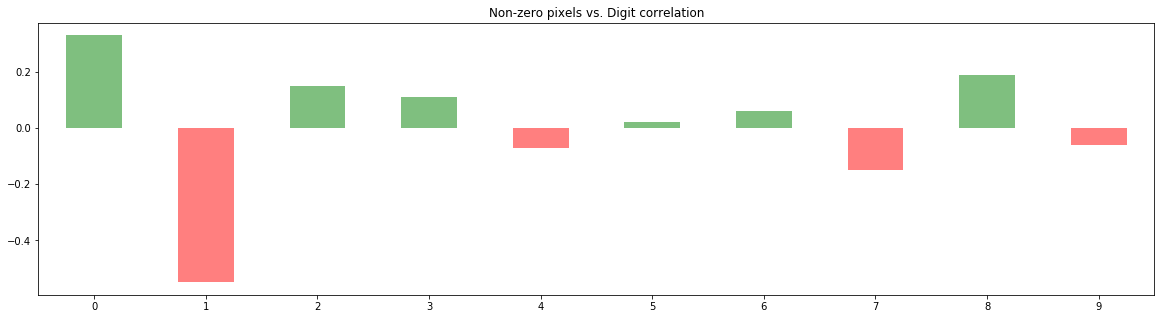

In [311]:
on_corr = df.corr()['On'][0:10].round(2)
on_corr.plot(kind='bar', figsize=(20, 5), color=['g' if c > 0 else 'r' for c in on_corr], alpha=0.5, rot=0,
            title='Non-zero pixels vs. Digit correlation')
pd.DataFrame(on_corr).T

In [308]:
X_new = pd.concat([X.sum(axis=1), (X != 0).sum(axis=1)], axis=1)
X_submit_new = pd.concat([X_submit.sum(axis=1), (X_submit != 0).sum(axis=1)], axis=1)

y_pred_new = LogisticRegression().fit(X_new, y).predict(pd.DataFrame(X_submit_new))
pd.Series(y_pred_new).value_counts()

0    12911
3     9368
5     5721
dtype: int64

Nice! finally some "results"! The cell below creates a submission file which can be submitted with the following bash line:

```bash

./scripts/submit.sh dummy_2_features_log_reg.csv "Dummy: logistic regression with sum of brighness and count of non zero pixels as features"
```

The solution achieves an accuracy of *0.12842*, reaching position *2737* (8 positions better than the previous one).

Not impressive, but the method is pretty barroque.


In [286]:
pd.DataFrame({'ImageId': range(1, 28001), 'Label': y_pred_new})\
    .to_csv(f"{DATA}/submissions/dummy_2_features_log_reg.csv", index=False)

## Amount of non-zero pixels by cuadrant

Last quick & dirt trial. Here we split each image in a grid of squares (2x2, 3x3, 4x4) and count the amount of non-zero pixel in each of those squares, generating a feature per square.

This solution achieves an accuracy of *0.88485*, which is a huge lift since the previous one. In terms of position, it's not as impressive though, we reached position 2623, 114 positions better than before. 

Actually, the position 1000 is still 99% ([Leaderboard]([https://www.kaggle.com/c/digit-recognizer/leaderboard)).

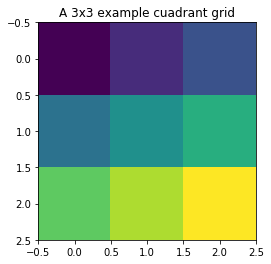

In [374]:
plt.imshow([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
plt.title('A 3x3 example cuadrant grid');

In [354]:
import itertools
def get_cuadrants(resolution=4):
    l = [(i, i+resolution) for i in list(range(0, 28, resolution))]
    return list(itertools.product(l, l))

get_cuadrants(14)

[((0, 14), (0, 14)),
 ((0, 14), (14, 28)),
 ((14, 28), (0, 14)),
 ((14, 28), (14, 28))]

In [364]:
def nozero_in_cuadrants(image, resolution=4):
    features = []
    for (x1, y1), (x2, y2) in get_cuadrants(resolution):
        nz_pixels = (image.values.reshape((28, 28))[x1:y1, x2:y2] != 0).sum().sum()
        features.append(nz_pixels)
    return pd.Series(features, index=[f"nonzero_pixels_cuadrant_{i}"for i in range(len(features))])

nozero_in_cuadrants(X.iloc[0], resolution=14)

nonzero_pixels_cuadrant_0     5
nonzero_pixels_cuadrant_1    44
nonzero_pixels_cuadrant_2    42
nonzero_pixels_cuadrant_3     6
dtype: int64

In [360]:
X_cuadrant = X.apply(nozero_in_cuadrants, axis=1)

X_submit_cuadrant = X_submit.apply(nozero_in_cuadrants, axis=1)

y_pred_cuadrant = LogisticRegression().fit(X_cuadrant, y).predict(pd.DataFrame(X_submit_cuadrant))
pd.Series(y_pred_cuadrant).value_counts()

In [353]:
pd.DataFrame({'ImageId': range(1, 28001), 'Label': y_pred_cuadrant})\
    .to_csv(f"{DATA}/submissions/dummy_cuadrant_resolution_4.csv", index=False)